In [19]:
import json
from pathlib import Path
import sagemaker
import boto3
sm_client = boto3.client('sagemaker')

## 事前準備

スクリプト、データセットをコピーする。詳細は `jsquad_preparation.py` を参照。

In [2]:
!python jsquad_preparation.py

Copy fine tuning code from the fine-tuning/instruction-tuning.
	Delete existing scripts folder.
Prepare JSQuAD dataset to data.
	Download train-v1.1.json.
	Download valid-v1.1.json.
Convert train-v1.1.json to instruction format.
	There are 710 titles (samples).
Split 62859 instruction data.
	 8 data is saved.
	 16 data is saved.
	 32 data is saved.
	 64 data is saved.
	 128 data is saved.
	 256 data is saved.
	 512 data is saved.
	 1024 data is saved.
	 2048 data is saved.
	 4096 data is saved.
	 15652 data is saved.
	 31105 data is saved.
	 45576 data is saved.
	 57086 data is saved.
	 62859 data is saved.
15 files are created.


In [12]:
with open("data/jsquad-00008.json", "r") as f:
    instructions = json.load(f)
    for key in instructions[0]:
        print(f"{key}:{instructions[0][key]}")

title_index:19
paragraph_index:16
question_index:0
question_id:a10807p23q0
input:工学 [SEP] コンピュータを利用することで、製品や部品の欠点を調べたり、部品同士のかみ合わせを調べたり、人間工学的な面を研究したり、圧力・温度・電磁波・電流と電圧・デジタル論理レベル・流体の流れ・動きなどシステムの静的および動的特性を解析できる。これらの情報を総合的に関するソフトウェアとして製品情報管理がある。
instruction:何を利用することで、製品や部品の欠点を調べたりできるか？
output:コンピュータ


## training job 起動

In [13]:
import sagemaker, boto3, json
from sagemaker import get_execution_role
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.huggingface import HuggingFace

role = get_execution_role()
region = boto3.Session().region_name
sess = sagemaker.Session()
bucket = sess.default_bucket()

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.197.0'

In [22]:
train_json_list = sorted(Path("data").glob("jsquad-*.json"))
for f in train_json_list:
    print(f.name)

jsquad-00008.json
jsquad-00016.json
jsquad-00032.json
jsquad-00064.json
jsquad-00128.json
jsquad-00256.json
jsquad-00512.json
jsquad-01024.json
jsquad-02048.json
jsquad-04096.json
jsquad-15652.json
jsquad-31105.json
jsquad-45576.json
jsquad-57086.json
jsquad-62859.json


In [23]:
input_s3_list = []
for train_json in train_json_list:
    input_train = sess.upload_data(
        path=str(train_json),
        key_prefix="jsquad"
    )
    input_s3_list.append(input_train)

training script はこちらを使用  
https://github.com/aws-samples/aws-ml-jp/tree/main/tasks/generative-ai/text-to-text/fine-tuning/instruction-tuning/Transformers/scripts

In [25]:
for s3_uri in input_s3_list[:1]:
    data_num = (s3_uri.split('/')[-1].split('.')[0]).split('-')[1]
    base_job_name=f"ft-rinna-{data_num}"
    hyperparameters={
        'base_model':'rinna/japanese-gpt-neox-3.6b-instruction-ppo',
        # 'load_in_8bit': True,
        # 'load_in_4bit': True,
        'data_path': f"/opt/ml/input/data/train/{s3_uri.split('/')[-1]}",
        'num_epochs': 3,
        'cutoff_len': 512,
        'group_by_length': False,
        'output_dir': '/opt/ml/model',
        'val_set_size':int(data_num)//8,
        # 'resume_from_checkpoint': '/opt/ml/checkpoints',
        'lora_target_modules': '[query_key_value]',
        'lora_r': 16,
        'batch_size': 8,
        'micro_batch_size': 8,
        'prompt_template_name': 'rinna',
        ## wandb setting
        'wandb_project': 'rinna-jsquad-finetune',
        'wandb_run_name': base_job_name,
        'wandb_watch': "gradients",  # options: false | gradients | all
        'wandb_log_model': "false",  # options: false | true
    }
    environment = {
        'WANDB_API_KEY': '(your_key)'
    }
    huggingface_estimator = HuggingFace(
        base_job_name=base_job_name,
        role=role,
        entry_point='finetune.py',
        source_dir='./scripts/code',
        instance_type='ml.g5.2xlarge',
        instance_count=1,
        volume_size=200,
        transformers_version='4.26',
        pytorch_version='1.13',
        py_version='py39',
        # use_spot_instances=True,
        # max_wait=86400,
        hyperparameters=hyperparameters,
        environment=environment,
        metric_definitions=[{'Name': 'eval_loss', 'Regex': "'eval_loss': (\d\.\d+)"},
                            {'Name': 'train_loss', 'Regex': "'loss': (\d\.\d+)"}],
        # checkpoint_s3_uri=f"s3://{bucket}/{base_job_name}/checkpoint/",
    )
    huggingface_estimator.fit({'train': s3_uri},wait=False)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: ft-rinna-00008-2023-12-21-09-24-05-544


---
## 出来上がったモデルを評価
## 以下は、全トレーニングジョブが終わってから実行のこと

In [63]:
paginator = sm_client.get_paginator('list_training_jobs')
training_jobs = []
for i, page in enumerate(paginator.paginate()):
    tmp_training_jobs = [{'TrainingJobName':training_job['TrainingJobName']} for training_job in page['TrainingJobSummaries']]    
    training_jobs = [*training_jobs, *tmp_training_jobs]
    if len(training_jobs) > 20:
        break

In [64]:
training_jobs = training_jobs[:16]
print(training_jobs)

[{'TrainingJobName': 'ft-rinna-62859-2023-12-10-08-15-15-471'}, {'TrainingJobName': 'ft-rinna-57086-2023-12-10-08-15-14-664'}, {'TrainingJobName': 'ft-rinna-45576-2023-12-10-08-15-12-610'}, {'TrainingJobName': 'ft-rinna-31105-2023-12-10-08-15-11-784'}, {'TrainingJobName': 'ft-rinna-15652-2023-12-10-08-15-11-001'}, {'TrainingJobName': 'ft-rinna-08192-2023-12-10-08-15-10-270'}, {'TrainingJobName': 'ft-rinna-04096-2023-12-10-08-15-07-287'}, {'TrainingJobName': 'ft-rinna-02048-2023-12-10-08-15-06-553'}, {'TrainingJobName': 'ft-rinna-01024-2023-12-10-08-15-05-753'}, {'TrainingJobName': 'ft-rinna-00512-2023-12-10-08-15-05-068'}, {'TrainingJobName': 'ft-rinna-00256-2023-12-10-08-15-04-216'}, {'TrainingJobName': 'ft-rinna-00128-2023-12-10-08-15-03-457'}, {'TrainingJobName': 'ft-rinna-00064-2023-12-10-08-15-01-610'}, {'TrainingJobName': 'ft-rinna-00032-2023-12-10-08-15-00-667'}, {'TrainingJobName': 'ft-rinna-00016-2023-12-10-08-14-59-184'}, {'TrainingJobName': 'ft-rinna-00008-2023-12-10-08-14-5

In [67]:
for i, training_job in enumerate(training_jobs):
    training_jobs[i]['S3ModelArtifacts'] = sm_client.describe_training_job(
        TrainingJobName=training_job['TrainingJobName'],
    )['ModelArtifacts']['S3ModelArtifacts']

In [68]:
training_jobs

[{'TrainingJobName': 'ft-rinna-62859-2023-12-10-08-15-15-471',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/ft-rinna-62859-2023-12-10-08-15-15-471/output/model.tar.gz'},
 {'TrainingJobName': 'ft-rinna-57086-2023-12-10-08-15-14-664',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/ft-rinna-57086-2023-12-10-08-15-14-664/output/model.tar.gz'},
 {'TrainingJobName': 'ft-rinna-45576-2023-12-10-08-15-12-610',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/ft-rinna-45576-2023-12-10-08-15-12-610/output/model.tar.gz'},
 {'TrainingJobName': 'ft-rinna-31105-2023-12-10-08-15-11-784',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/ft-rinna-31105-2023-12-10-08-15-11-784/output/model.tar.gz'},
 {'TrainingJobName': 'ft-rinna-15652-2023-12-10-08-15-11-001',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/ft-rinna-15652-2023-12-10-08-15-11-001/output/model.tar.gz'},
 {'TrainingJobName': 'ft-rinna-08192-2023-12-10-08-15-10-270',
  'S3Mo

In [69]:
peft_path_list = []
for i, training_job in enumerate(training_jobs):
    model_uri = training_job['S3ModelArtifacts']
    peft_path = training_job['TrainingJobName'].split('-')[2]
    peft_path_list.append(peft_path)
    !mkdir -p {peft_path}
    !aws s3 cp {model_uri} ./{peft_path}
    !tar zxvf ./{peft_path}/model.tar.gz -C ./{peft_path}/
    !rm ./{peft_path}/model.tar.gz
    !rm -r ./{peft_path}/checkpoint-*

download: s3://sagemaker-us-east-1-290000338583/ft-rinna-62859-2023-12-10-08-15-15-471/output/model.tar.gz to 62859/model.tar.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
adapter_config.json
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
checkpoint-41200/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
checkpoint-41200/adapter_config.json
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
checkpoint-41200/optimizer.pt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
checkpoint-41200/rng_state.pth
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
checkpoint-41200/adapter_model.bin
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
checkpoint-41200/training_args.bin
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
checkpoint-41200/trainer_state.json
tar: Ignoring unknown extended header keyword 'LIBARC

In [70]:
bucket = sagemaker.session.Session().default_bucket()
peft_prefix = 'jsquad/peft'
!aws s3 rm --recursive s3://{bucket}/{peft_prefix}
peft_s3_list = []
for peft_path in peft_path_list:
    peft_s3_uri = sess.upload_data(
        path=peft_path,
        key_prefix=f'/{peft_prefix}/{peft_path}'
    )
    peft_s3_list.append(peft_s3_uri)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft/00008/adapter_config.json
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft/00008/adapter_model.bin
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft/00016/adapter_config.json
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft/00064/adapter_config.json
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft/00064/adapter_model.bin
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft/01024/adapter_model.bin
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft/04096/adapter_config.json
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft/00016/adapter_model.bin
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft/04096/adapter_model.bin
delete: s3://sagemaker-us-east-1-290000338583/jsquad/peft

source_dir は https://github.com/Stability-AI/lm-evaluation-harness/tree/jp-stable をコピーして使用。entrypoint.py のみ自作。  
なぜか `device_map_option=auto` 引数が効かずに落ちたため、`lm_eval/models/huggingface.py` の `device_map=device_map,` を `device_map='auto'`,に書き換えた。

In [72]:
# with peft の評価
for peft_s3_uri in peft_s3_list:
    base_job_name=f"eval-jsquad-{peft_s3_uri.split('/')[-1]}"
    print(base_job_name)
    huggingface_estimator = HuggingFace(
        base_job_name=base_job_name,
        role=role,
        entry_point='entrypoint.py',
        source_dir='./lm-evaluation-harness/',
        instance_type='ml.g5.2xlarge',
        instance_count=1,
        volume_size=200,
        transformers_version='4.28.1',
        pytorch_version='2.0.0',
        py_version='py310',
        max_run=3*24*60*60,
        hyperparameters={
            'model': 'rinna/japanese-gpt-neox-3.6b-instruction-ppo',
            'peft' : 'peft',
            'task' : 'jsquad-1.1-0.4',
            'num_fewshot':'2'
        }
    )
    huggingface_estimator.fit({'train': peft_s3_uri},wait=False)

# without peft の評価
huggingface_estimator = HuggingFace(
    base_job_name='rinna-ppo-without-peft',
    role=role,
    entry_point='entrypoint.py',
    source_dir='./lm-evaluation-harness/',
    instance_type='ml.g5.2xlarge',
    instance_count=1,
    volume_size=200,
    transformers_version='4.28.1',
    pytorch_version='2.0.0',
    py_version='py310',
    max_run=3*24*60*60,
    hyperparameters={
        'model': 'rinna/japanese-gpt-neox-3.6b-instruction-ppo',
        'task' : 'jsquad-1.1-0.4',
        'num_fewshot':'2'
    }
)
huggingface_estimator.fit(wait=False)

eval-jsquad-62859
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-62859-2023-12-11-09-11-25-622


eval-jsquad-57086
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-57086-2023-12-11-09-11-29-583


eval-jsquad-45576
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-45576-2023-12-11-09-11-32-632


Using provided s3_resource
eval-jsquad-31105
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-31105-2023-12-11-09-11-35-680


eval-jsquad-15652
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-15652-2023-12-11-09-11-38-964


Using provided s3_resource
eval-jsquad-08192
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-08192-2023-12-11-09-11-41-845


eval-jsquad-04096
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: eval-jsquad-04096-2023-12-11-09-11-45-198


eval-jsquad-02048
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: eval-jsquad-02048-2023-12-11-09-11-47-975


eval-jsquad-01024
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-01024-2023-12-11-09-11-51-052


eval-jsquad-00512
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: eval-jsquad-00512-2023-12-11-09-11-54-154


eval-jsquad-00256
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-00256-2023-12-11-09-11-57-432


eval-jsquad-00128
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: eval-jsquad-00128-2023-12-11-09-12-00-449


eval-jsquad-00064
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: eval-jsquad-00064-2023-12-11-09-12-03-813


eval-jsquad-00032
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-00032-2023-12-11-09-12-07-097


Using provided s3_resource
eval-jsquad-00016
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-00016-2023-12-11-09-12-10-215


eval-jsquad-00008
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: eval-jsquad-00008-2023-12-11-09-12-13-653


Using provided s3_resource
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: rinna-ppo-without-peft-2023-12-11-09-12-16-945


## 評価結果の回収
## 以下は、評価ジョブが全て終わってから実行のこと

In [74]:
paginator = sm_client.get_paginator('list_training_jobs')
evaluate_jobs = []
for i, page in enumerate(paginator.paginate()):
    tmp_evaluate_jobs = [{'TrainingJobName':training_job['TrainingJobName']} for training_job in page['TrainingJobSummaries']]    
    evaluate_jobs = [*evaluate_jobs, *tmp_evaluate_jobs]
    if len(evaluate_jobs) > 20:
        break

In [76]:
evaluate_jobs = evaluate_jobs[0:17]
evaluate_jobs

[{'TrainingJobName': 'rinna-ppo-without-peft-2023-12-11-09-12-16-945'},
 {'TrainingJobName': 'eval-jsquad-00008-2023-12-11-09-12-13-653'},
 {'TrainingJobName': 'eval-jsquad-00016-2023-12-11-09-12-10-215'},
 {'TrainingJobName': 'eval-jsquad-00032-2023-12-11-09-12-07-097'},
 {'TrainingJobName': 'eval-jsquad-00064-2023-12-11-09-12-03-813'},
 {'TrainingJobName': 'eval-jsquad-00128-2023-12-11-09-12-00-449'},
 {'TrainingJobName': 'eval-jsquad-00256-2023-12-11-09-11-57-432'},
 {'TrainingJobName': 'eval-jsquad-00512-2023-12-11-09-11-54-154'},
 {'TrainingJobName': 'eval-jsquad-01024-2023-12-11-09-11-51-052'},
 {'TrainingJobName': 'eval-jsquad-02048-2023-12-11-09-11-47-975'},
 {'TrainingJobName': 'eval-jsquad-04096-2023-12-11-09-11-45-198'},
 {'TrainingJobName': 'eval-jsquad-08192-2023-12-11-09-11-41-845'},
 {'TrainingJobName': 'eval-jsquad-15652-2023-12-11-09-11-38-964'},
 {'TrainingJobName': 'eval-jsquad-31105-2023-12-11-09-11-35-680'},
 {'TrainingJobName': 'eval-jsquad-45576-2023-12-11-09-11-

In [ ]:
# evaluate_jobs = [
#     {'TrainingJobName': 'eval-jsquad-00008-2023-12-04-00-28-38-320'}, 
#     {'TrainingJobName': 'eval-jsquad-00016-2023-12-04-00-28-35-338'}, 
#     {'TrainingJobName': 'eval-jsquad-00032-2023-12-04-00-28-32-532'}, 
#     {'TrainingJobName': 'eval-jsquad-00064-2023-12-04-00-28-29-460'}, 
#     {'TrainingJobName': 'eval-jsquad-00128-2023-12-04-00-28-26-510'}, 
#     {'TrainingJobName': 'eval-jsquad-15652-2023-12-04-00-28-23-847'}, 
#     {'TrainingJobName': 'eval-jsquad-31105-2023-12-04-00-28-20-894'}, 
#     {'TrainingJobName': 'eval-jsquad-45576-2023-12-04-00-28-18-034'}, 
#     {'TrainingJobName': 'eval-jsquad-57086-2023-12-04-00-28-14-813'}, 
#     {'TrainingJobName': 'eval-jsquad-62859-2023-12-04-00-28-11-201'}
# ]

In [77]:
for i, evaluate_job in enumerate(evaluate_jobs):
    evaluate_jobs[i]['S3ModelArtifacts'] = sm_client.describe_training_job(
        TrainingJobName=evaluate_job['TrainingJobName'],
    )['ModelArtifacts']['S3ModelArtifacts']

In [78]:
evaluate_jobs

[{'TrainingJobName': 'rinna-ppo-without-peft-2023-12-11-09-12-16-945',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/rinna-ppo-without-peft-2023-12-11-09-12-16-945/output/model.tar.gz'},
 {'TrainingJobName': 'eval-jsquad-00008-2023-12-11-09-12-13-653',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/eval-jsquad-00008-2023-12-11-09-12-13-653/output/model.tar.gz'},
 {'TrainingJobName': 'eval-jsquad-00016-2023-12-11-09-12-10-215',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/eval-jsquad-00016-2023-12-11-09-12-10-215/output/model.tar.gz'},
 {'TrainingJobName': 'eval-jsquad-00032-2023-12-11-09-12-07-097',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/eval-jsquad-00032-2023-12-11-09-12-07-097/output/model.tar.gz'},
 {'TrainingJobName': 'eval-jsquad-00064-2023-12-11-09-12-03-813',
  'S3ModelArtifacts': 's3://sagemaker-us-east-1-290000338583/eval-jsquad-00064-2023-12-11-09-12-03-813/output/model.tar.gz'},
 {'TrainingJobName': 'eval-jsq

In [79]:
result_path_list = []
for i, evaluate_job in enumerate(evaluate_jobs):
    model_uri = evaluate_job['S3ModelArtifacts']
    result_path = 'eval_' + evaluate_job['TrainingJobName'].split('-')[2]
    result_path_list.append(result_path)
    !mkdir -p {result_path}
    !aws s3 cp {model_uri} ./{result_path}
    !tar zxvf ./{result_path}/model.tar.gz -C ./{result_path}/
    !rm ./{result_path}/model.tar.gz

download: s3://sagemaker-us-east-1-290000338583/rinna-ppo-without-peft-2023-12-11-09-12-16-945/output/model.tar.gz to eval_without/model.tar.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
result.json
download: s3://sagemaker-us-east-1-290000338583/eval-jsquad-00008-2023-12-11-09-12-13-653/output/model.tar.gz to eval_00008/model.tar.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
result.json
download: s3://sagemaker-us-east-1-290000338583/eval-jsquad-00016-2023-12-11-09-12-10-215/output/model.tar.gz to eval_00016/model.tar.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
result.json
download: s3://sagemaker-us-east-1-290000338583/eval-jsquad-00032-2023-12-11-09-12-07-097/output/model.tar.gz to eval_00032/model.tar.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
result.json
download: s3://sagemaker-us-east-1-290000338583/eval-jsquad-00064-2023-12-11-09-12-03-813/output/model.tar.gz

In [80]:
result = {
    'data_num':[],
    'f1':[],
    'exact_match':[]
}
for result_path in result_path_list:
    with open(os.path.join(result_path,'result.json')) as f:
        data_num = result_path.split('_')[1]
        data_num =  0 if result_path.split('_')[1] == 'without' else int(result_path.split('_')[1])
        result_dict = json.loads(f.read())
        f1 = result_dict['results']['jsquad-1.1-0.4']['f1']
        exact_match = result_dict['results']['jsquad-1.1-0.4']['exact_match']
        result['data_num'].append(data_num)
        result['f1'].append(f1)
        result['exact_match'].append(exact_match)

In [81]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'score')

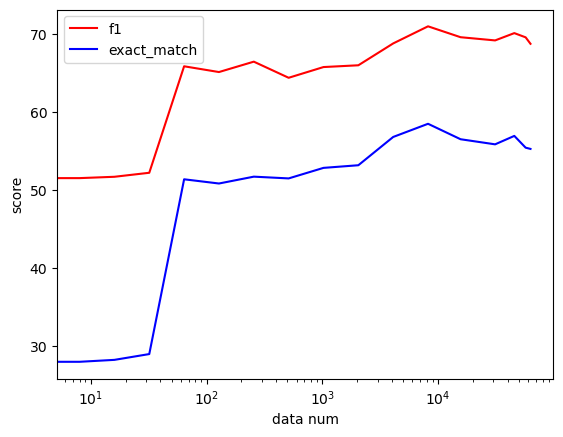

In [83]:
fix,ax = plt.subplots()

ax.plot(result['data_num'],result['f1'],color='red',label='f1')
ax.plot(result['data_num'],result['exact_match'],color='blue',label='exact_match')

plt.xscale('log')
plt.legend()
ax.set_xlabel('data num')
ax.set_ylabel('score')

Text(0, 0.5, 'score')

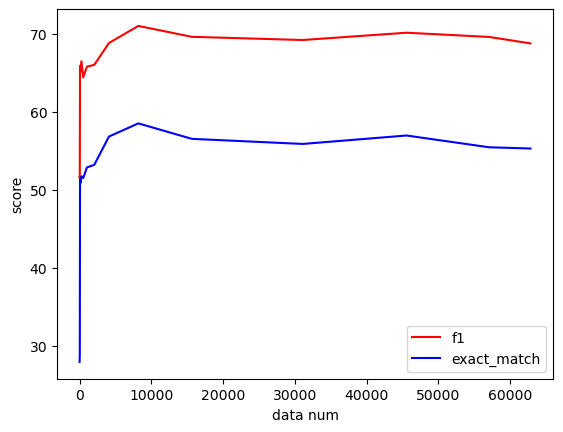

In [84]:
fix,ax = plt.subplots()

ax.plot(result['data_num'],result['f1'],color='red',label='f1')
ax.plot(result['data_num'],result['exact_match'],color='blue',label='exact_match')

plt.legend()
ax.set_xlabel('data num')
ax.set_ylabel('score')

In [89]:
import pandas as pd
pd.DataFrame(result)

,data_num,f1,exact_match
0,0,51.588303,27.960378
1,8,51.568292,28.027915
2,16,51.740004,28.275552
3,32,52.253612,29.018460
4,64,65.901630,51.418280
5,128,65.163149,50.877983
6,256,66.494346,51.755966
7,512,64.428221,51.530842
8,1024,65.802912,52.881585
9,2048,66.030597,53.219271
